# Отток клиентов

## Цели проекта

* Проанализировать исторические данные о поведении клиентов и расторжении договоров с банком. 
* Спрогнозировать уход клиента из банка в ближайшее время.
* Построить модель классификации, метрика качества f1 (минимальное значение 0.59)
* Измерить AUC-ROC, сравнить её значение с f1-мерой.

## Ход работы

* Подготовка данных
    1. Загрузка данных
    2. Подготовка признаков
* Исследование задачи
    1. Решающее дерево
    2. Случайный лес
    3. Логистическая регрессия
* Борьба с дисбалансом
    1. Взвешивание классов
    2. Upsampling 
    3. Downsampling
* Тестирование модели
* Общий вывод

## Описание данных:

Признаки
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата


Целевой признак
* `Exited` — факт ухода клиента

## Подготовка данных

### Загрузка данных

Иморт необходимых библиотек:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

pd.set_option("display.max_columns", None)

Загрузим данные, выведем первые 10 строк, оценим характеристики таблицы:

In [2]:
try:
    df = pd.read_csv("/datasets/Churn.csv")
except:
    df = pd.read_csv("datasets/Churn.csv")
display(df.head(10))
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Подготовка признаков

#### Дубликаты

Поиск дубликатов:

In [3]:
df.duplicated().sum()

0

Явных дубликатов нет.

#### Количественные признаки

Есть пропуски в столбце "Tenure".

In [4]:
print("Количество пропусков = ", df["Tenure"].isna().sum())
print(
    "Доля пропусков = ",
    round(100 * df["Tenure"].isna().sum() / df["Tenure"].count(), 3),
    "%",
)

Количество пропусков =  909
Доля пропусков =  9.999 %


Доля пропусков довольно большая, избавляться от них не будем. Заполним пропуски медианным значением годов.

In [5]:
df.loc[df["Tenure"].isna(), "Tenure"] = int(df["Tenure"].median())

Проверим на выбросы количественные признаки:

In [6]:
def show_numerics(d, data_label1="", data_label2=""):
    if data_label2 != "":
        f, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].set_title("Диаграмма размаха для " + data_label1)
        sns.boxplot(data=d, x=data_label1, ax=axes[0])
        axes[1].set_title("Диаграмма размаха для " + data_label2)
        sns.boxplot(data=d, x=data_label2, ax=axes[1])
    else:
        f, axes = plt.subplots(1, 1, figsize=(8, 4))
        axes.set_title("Диаграмма размаха для " + data_label1)
        sns.boxplot(data=d, x=data_label1, ax=axes)
    plt.xticks(rotation=45)
    plt.show()

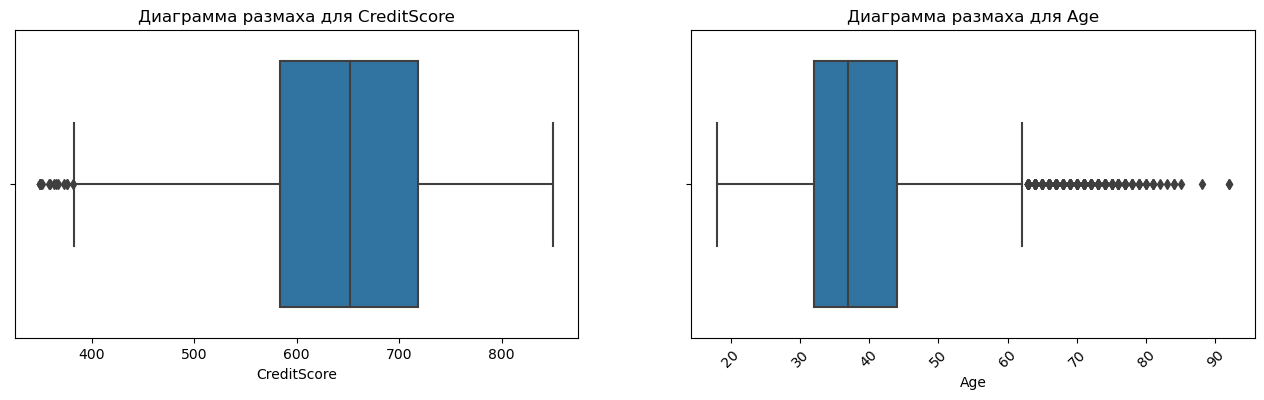

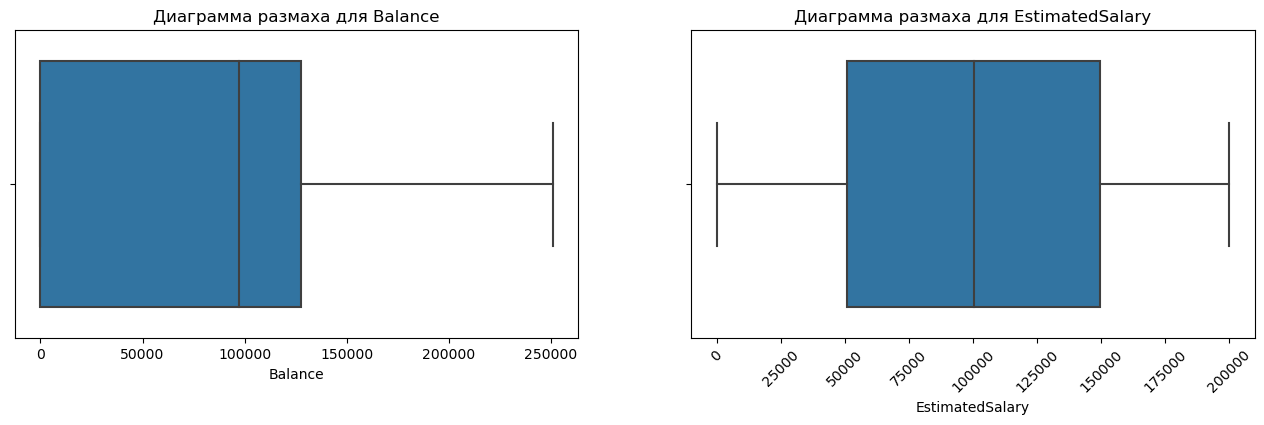

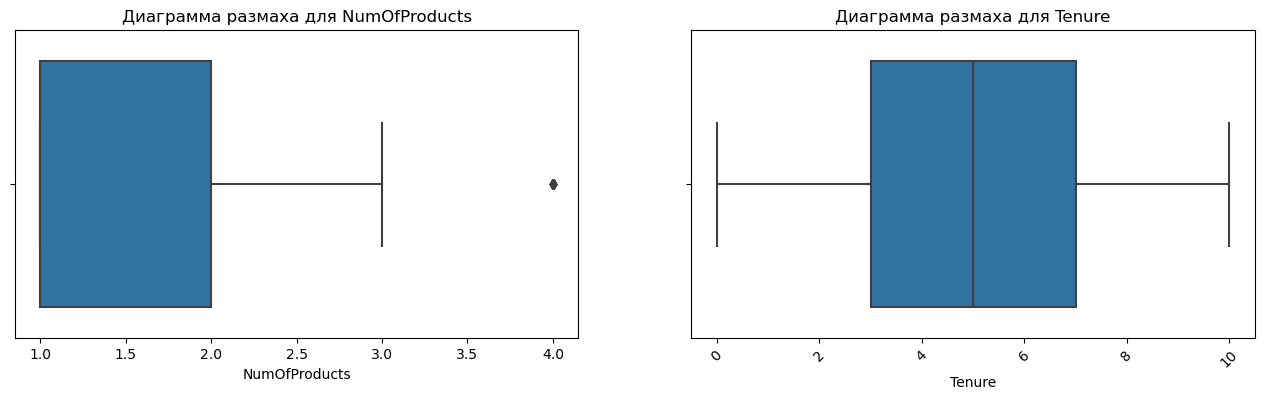

In [7]:
numerics = [
    "CreditScore",
    "Age",
    "Balance",
    "EstimatedSalary",
    "NumOfProducts",
    "Tenure",
]

for i in range(len(numerics) // 2):
    show_numerics(df, numerics[2 * i], numerics[2 * i + 1])

В целом все данные корректные (возраст 90+ вполне допустим,учитывая, что рассматриваются Европейские страны с высоким уровнем жизни и продолжительностью). 


#### Категориальные признаки

Отобразим сколько и какие данные содержатся в категориальных столбцах:

In [8]:
def show_categorical(d, data_label1, data_label2=""):
    if data_label2 != "":
        f, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].set_title("Количество данных для " + data_label1)
        sns.countplot(data=d, x=data_label1, ax=axes[0])
        axes[0].set_ylabel("Шт.")
        
        axes[1].set_title("Количество данных для " + data_label2)
        sns.countplot(data=d, x=data_label2, ax=axes[1])
        axes[1].set_ylabel("Шт.")
    else:
        f, axes = plt.subplots(1, 1, figsize=(8, 4))
        axes.set_title("Количество данных для " + data_label1)
        sns.countplot(data=d, x=data_label1, ax=axes)
        axes.set_ylabel("Шт.")
    plt.show()


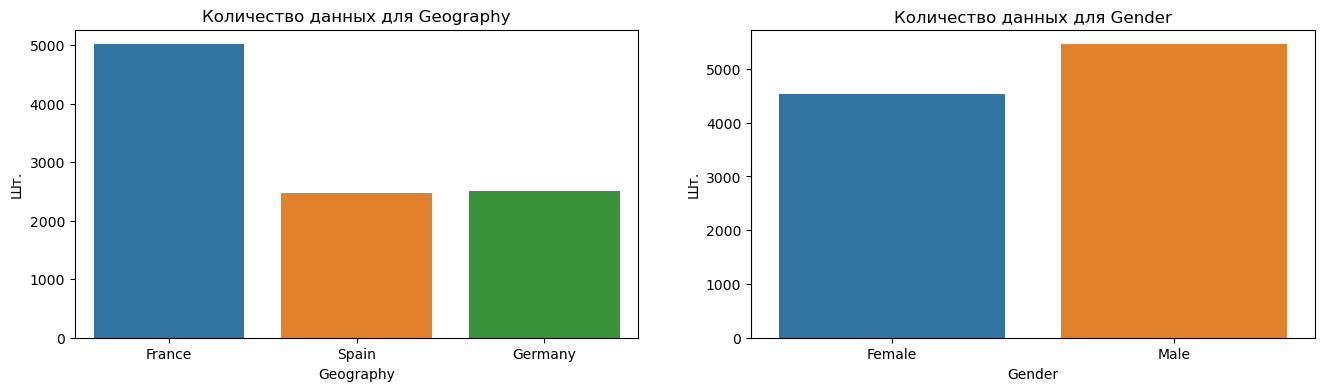

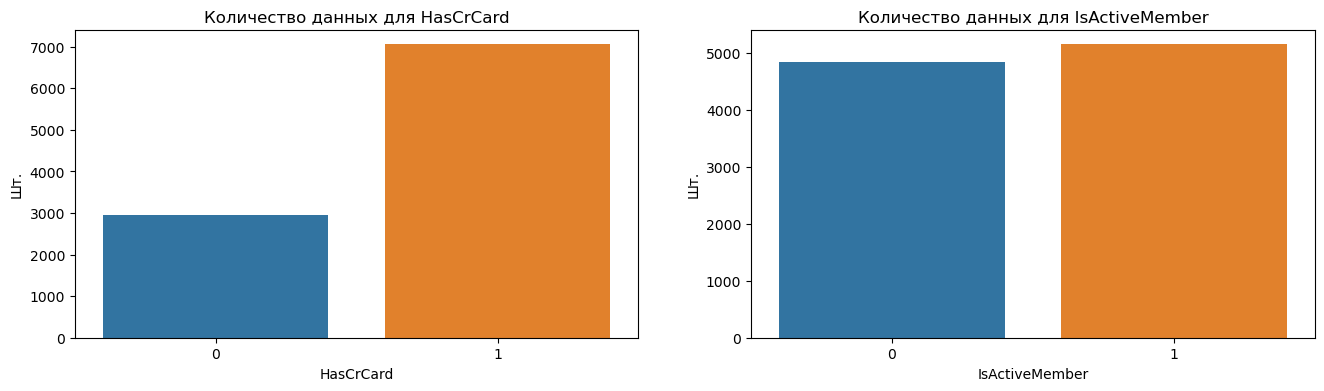

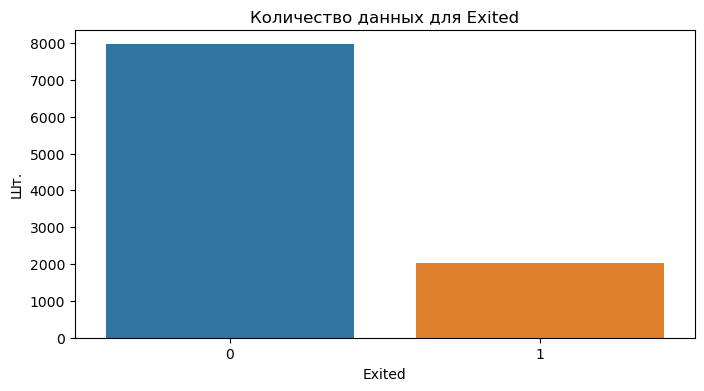

In [9]:
categoricals = ["Geography", "Gender", "HasCrCard", "IsActiveMember", "Exited", ""]
for i in range(len(categoricals) // 2):
    show_categorical(df, categoricals[2 * i], categoricals[2 * i + 1])

Разновидность данных в столбцах *'Geography', 'Gender'* небольшая, можем преобразовать в численный признак с помощью прямого кодирования:

In [10]:
# для преобразования воспользуемся методом pd.get_dummies
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Что касается целевого признака 'Exited', то видим, что есть дисбаланс: нулевых значений в 4 раза больше чем единиц.

Логично предположить, что данные в колонках *'RowNumber', 'CustomerId', 'Surname'* никак не влияют на то уйдет клиент из банка или нет. Избавимся от этих данных:

In [11]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


#### Вывод

* Данные успешно загружены. Дубликатов нет.
* В целом можно сказать, что выбросов нет.
* Категориальные признаки преобразованы методом One-Hot Encoder.
* В целевом признаке сооотношение положительных и отрицательных значений равно 1:4 (наблюдается дисбаланс).
* В признаке *Tenure* примерно 10% пропусков. Пропуски были заполнены медианным значением.
* Избавились от колонок, которые никак не влияют на целевой признак.

## Исследование задачи

В первую очередь разделим данные на признаки и целевой признак:

In [12]:
features = df.drop("Exited", axis=1)
target = df["Exited"]

Далее разобъем данные на обучающую, валидационную и тестовую выборку (пропорции 3:1:1) и масштабируем количественные признаки:

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345
)

# Применим к количественным данным масштабировние с помощью *StandardScaler* библиотеки *sklearn*:
scaler = StandardScaler()
numerics = [
    "CreditScore",
    "Age",
    "Balance",
    "EstimatedSalary",
    "NumOfProducts",
    "Tenure",
]
pd.options.mode.chained_assignment = None
scaler.fit(features_train[numerics])
features_train[numerics] = scaler.transform(features_train[numerics])
features_valid[numerics] = scaler.transform(features_valid[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])
# проверим сработало ли масштабирование
display(features_train.head())

# для проверки разбиения
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0


(6000,)
(2000,)
(2000,)


Далее пробуем обучить различные классификационные модели без учёта дисбаланса, в которых метрикой качества будут f1 и roc_auc:

### Решающее дерево

Переберем и выберем гиперпараметры, которые обеспечат лучшую метрику качества f1 и найдем соответствующую этим параметрам roc_auc:
* max_depth - максимальная глубина дерева
* min_samples_split - минимальное количество объектов в узле
* min_samples_leaf - минимальное количество объектов в листе
* criterion ("gini" или "entropy") - функция измерения качества разделени
* class_weight - вес класса


In [14]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw=None):
    # в параметрах best_params_f1 храним гиперпараметры для best_f1
    best_params_f1 = []
    best_f1 = 0

    roc_auc_interest = 0.5
    # проходим в циклах по гиперпараметрам
    # для прогресса
    i = 0
    for max_depth in range(2, 10):
        for min_samples_split in range(2, 10):
            for min_samples_leaf in range(1, 10):
                for criterion in ["gini", "entropy"]:
                    model_dt_clf = DecisionTreeClassifier(
                        random_state=12345,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        criterion=criterion,
                        class_weight=cw,
                    )
                    # обучение модели
                    model_dt_clf.fit(X_train, y_train)
                    # поиск предсказаний
                    predictions = model_dt_clf.predict(X_valid)
                    # вычисление f1
                    f1 = f1_score(y_valid, predictions)
                    # аналогично для метрики roc_auc
                    probabilities_valid = model_dt_clf.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения,
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [
                            max_depth,
                            min_samples_split,
                            min_samples_leaf,
                            criterion,
                            cw,
                        ]
                        best_f1 = f1
                        roc_auc_interest = roc_auc
                    i += 1
                    print(
                        "Готовность расчетов: " + str(round(i / 1152 * 100, 3)) + "%",
                        end="\r",
                    )

    print("Готовность расчетов: " + str(round(i / 1152 * 100, 3)))
    print(
        """Наилучшая метрика f1: {}
    Параметры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {}\n""".format(
            round(best_f1, 3),
            best_params_f1[0],
            best_params_f1[1],
            best_params_f1[2],
            best_params_f1[3],
        )
    )

    # вывод соответствующей метрики roc_auc
    print("Соответствующая метрика roc_auc: {}".format(round(roc_auc_interest, 3)))

In [15]:
%%time
decision_tree(features_train, features_valid, target_train, target_valid)

Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.578
    Параметры модели:
       max_depth = 6
       min_samples_split = 8
       min_samples_leaf = 2
       criterion = gini

Соответствующая метрика roc_auc: 0.825
CPU times: total: 23.9 s
Wall time: 26 s


Метрика f1 ниже, чем было задано в тех.задании(0.59).

### Случайный лес

Переберем и выберем гиперпараметры, которые обеспечат лучшую метрику качества f1 и найдем соответствующую этим параметрам roc_auc:

* n_estimators - количество деревьев
* max_depth - максимальная глубина дерева
* min_samples_split - минимальное количество объектов в узле
* min_samples_leaf - минимальное количество объектов в листе

In [16]:
def random_forest(X_train, X_valid, y_train, y_valid, cw=None):
    # в параметрах best_params_f1 храним гиперпараметры для best_f1
    best_params_f1 = []
    best_f1 = 0
    roc_auc_interest = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    i = 0
    for n_estimators in range(2, 21, 2):
        for max_depth in range(10, 21, 2):
            for min_samples_split in range(5, 13):
                for min_samples_leaf in range(1, 5):
                    # инициализация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(
                        random_state=12345,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        class_weight=cw,
                    )
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)

                    # аналогично для метрики roc_auc
                    probabilities_valid = model_rf_clf.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения,
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [
                            n_estimators,
                            max_depth,
                            min_samples_split,
                            min_samples_leaf,
                        ]
                        best_f1 = f1
                        roc_auc_interest = roc_auc
                    i += 1
                    print(
                        "Готовность расчетов: " + str(round(i / 1920 * 100, 3)) + "%",
                        end="\r",
                    )

    print("Готовность расчетов: " + str(round(i / 1920 * 100, 3)))

    # вывод наилучшей метрики f1 и параметров модели.
    print(
        """Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n""".format(
            round(best_f1, 3),
            best_params_f1[0],
            best_params_f1[1],
            best_params_f1[2],
            best_params_f1[3],
        )
    )

    # вывод соответствующей метрики roc_auc
    print("Соответствующая метрика roc_auc: {}".format(round(roc_auc_interest, 3)))

In [17]:
%%time
random_forest(features_train, features_valid, target_train, target_valid)

Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.616
    Парамтеры модели:
       n_estimators = 16
       max_depth = 20
       min_samples_split = 11
       min_samples_leaf = 1 

Соответствующая метрика roc_auc: 0.833
CPU times: total: 3min 27s
Wall time: 3min 42s


f1 показала значение выше, чем было задано в тех.задании(0.616>0.59) и roc_auc тоже выше, чем для "Дерева решений" (0.833>0.825).

### Логистическая регрессия

Переберем и выберем гиперпараметры, которые обеспечат лучшую метрику качества f1 и найдем соответствующую этим параметрам roc_auc:
* С - инверсия силы регуляризации
* max_iter - максимальное количество итераций
* solver - алгоритм оптимизации

In [18]:
def log_regress(X_train, X_valid, y_train, y_valid, cw=None):
    # в параметрах best_params_f1 храним гиперпараметры для best_f1
    best_params_f1 = []
    best_f1 = 0
    # в параметрах best_params_roc_auc храним гиперпараметры для best_roc_auc
    best_params_roc_auc = []
    best_roc_auc = 0.5

    cs = range(1, 11, 1)
    max_iteration = range(100, 1001, 100)

    # проходим в циклах по всем выбранным гиперпараметрам
    i = 0
    for C in cs:
        for max_iter in max_iteration:
            for solver in ["lbfgs", "liblinear"]:
                # инициация модели с текущими гиперпараметрами
                model_lr_clf = LogisticRegression(
                    random_state=12345,
                    C=C,
                    max_iter=max_iter,
                    solver=solver,
                    class_weight=cw,
                )
                # обучение модели на тренировочной выборке
                model_lr_clf.fit(X_train, y_train)
                # поиск предсказаний модели на валидационной выбоке
                predictions = model_lr_clf.predict(X_valid)

                # аналогично для метрики roc_auc
                probabilities_valid = model_lr_clf.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
                # вычисление f1 модели методом f1_score
                f1 = f1_score(y_valid, predictions)
                # если текущее значение метрики f1 выше предыдущего лучшего значения,
                # сохраняем параметры модели и текущую метрику f1
                if f1 > best_f1:
                    best_params_f1 = [C, max_iter, solver]
                    best_f1 = f1
                    roc_auc_interest = roc_auc
                i += 1
                print(
                    "Готовность расчетов: " + str(round(i / 200 * 100, 3)) + "%",
                    end="\r",
                )
    print("Готовность расчетов: " + str(round(i / 200 * 100, 3)))

    # вывод наилучшей метрики f1 и параметров модели.
    print(
        """Наилучшая метрика f1: {}
    Параметры модели:
       С = {}
       max_iter = {}
       solver = {} \n""".format(
            round(best_f1, 3), best_params_f1[0], best_params_f1[1], best_params_f1[2]
        )
    )

    # вывод соответствующей метрики roc_auc
    print("Соответствующая метрика roc_auc: {}".format(round(roc_auc_interest, 3)))

In [19]:
%%time
log_regress(features_train, features_valid, target_train, target_valid)

Готовность расчетов: 100.0%
Наилучшая метрика f1: 0.331
    Параметры модели:
       С = 1
       max_iter = 100
       solver = lbfgs 

Соответствующая метрика roc_auc: 0.759
CPU times: total: 15.8 s
Wall time: 2.35 s


Метрика f1 совсем далека от установленного значения 0.59.

### Вывод

* Данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.
* Масштабированы числовые признаки.
* Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики **f1 = 0.616** получено при обучении модели типа "Случайный лес". Качество модели удовлетворяет условию технического задания (>0.59).
* Соответствующее максимальной метрике f1 метрика **roc_auc = 0.833**.

## Борьба с дисбалансом

Напомним, что соотношение значений целевого признака 4:1 (для классов 0 и 1 соответственно).<br>
Для борьбы с дисбалансом классов попробуем:
* взвешивание классов (class_weight='balanced')
* увеличение выборки положительного класса (upsampling)
* уменьшение выборки отрицательного класса (downsampling )

### Взвешивание классов

Взвешивание классов для "Дерева решений":

In [20]:
%%time
decision_tree(features_train, features_valid, target_train, target_valid, cw="balanced")

Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.601
    Параметры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 7
       criterion = entropy

Соответствующая метрика roc_auc: 0.835
CPU times: total: 30.1 s
Wall time: 30.7 s


* Взвешивание классов дало прирост в метрике f1 (0.601>0.578), теперь значение f1 выше заданного в тех.задании 0.59.
* Взвешивание классов дало прирост и в метрике roc_auc (0.835>0.825).

Взвешивание классов для "Случайного леса":

In [21]:
%%time
random_forest(features_train, features_valid, target_train, target_valid, cw="balanced")

Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.639
    Парамтеры модели:
       n_estimators = 18
       max_depth = 10
       min_samples_split = 12
       min_samples_leaf = 4 

Соответствующая метрика roc_auc: 0.851
CPU times: total: 3min 24s
Wall time: 3min 37s


* Взвешивание классов дало прирост в метрике f1 (0.639>0.616).
* Взвешивание классов дало прирост и в метрике roc_auc (0.851>0.833).

In [22]:
%%time
log_regress(features_train, features_valid, target_train, target_valid, cw="balanced")

Готовность расчетов: 100.0%
Наилучшая метрика f1: 0.489
    Параметры модели:
       С = 1
       max_iter = 100
       solver = lbfgs 

Соответствующая метрика roc_auc: 0.764
CPU times: total: 16.5 s
Wall time: 2.63 s


* Взвешивание классов дало прирост в метрике f1 (0.489>0.331).
* Взвешивание классов дало прирост и в метрике roc_auc (0.764>0.759).
* Далее можно не рассматривать логистическую регрессию так как явно уступает двум другим моделям.

### Upsampling

Перебирая параметр repeat (во сколько раз увеличить количество положительных целевых признаков), обучим "Дерево решений" и "Случайный лес":

In [23]:
# функция для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )
    return features_upsampled, target_upsampled

In [24]:
for repeat in range(2, 5, 1):
    print("При repeat = ", repeat)
    X_train_upsampled, y_train_upsampled = upsample(
        features_train, target_train, repeat
    )
    print("Решающее дерево:")
    decision_tree(X_train_upsampled, features_valid, y_train_upsampled, target_valid)
    print("Случайный лес:")
    random_forest(X_train_upsampled, features_valid, y_train_upsampled, target_valid)
    print("=============================================================")

При repeat =  2
Решающее дерево:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.608
    Параметры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 6
       criterion = gini

Соответствующая метрика roc_auc: 0.831
Случайный лес:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.645
    Парамтеры модели:
       n_estimators = 18
       max_depth = 10
       min_samples_split = 11
       min_samples_leaf = 4 

Соответствующая метрика roc_auc: 0.845
При repeat =  3
Решающее дерево:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.599
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 9
       criterion = gini

Соответствующая метрика roc_auc: 0.823
Случайный лес:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.643
    Парамтеры модели:
       n_estimators = 16
       max_depth = 12
       min_samples_split = 12
       min_samples_leaf = 1 

Соответствующая метрика roc_auc: 0.845
При repeat =

* C помощью *repeat*=**2** удалось улучшить метрику f1 для "Решающего дерева" до  **0.608**, при этом  roc_auc=**0.831**.
    * Параметры модели:
       * max_depth = 6
       * min_samples_split = 2
       * min_samples_leaf = 6
       * criterion = gini
* C помощью *repeat*=**2** удалось улучшить метрику f1 для "Случайного леса" до  **0.645**, при этом  roc_auc=**0.845**.
    * Параметры модели:
       * n_estimators = 18
       * max_depth = 10
       * min_samples_split = 11
       * min_samples_leaf = 4 

### Unsampling

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )
    return features_downsampled, target_downsampled

In [26]:
for frac in np.arange(0.2, 0.5, 0.1):
    print("При frac = ", frac)
    print("")
    X_train_downsampled, y_train_downsampled = downsample(
        features_train, target_train, frac
    )
    print("Решающее дерево:")
    decision_tree(
        X_train_downsampled, features_valid, y_train_downsampled, target_valid
    )
    print("")
    print("Случайный лес:")
    random_forest(
        X_train_downsampled, features_valid, y_train_downsampled, target_valid
    )
    print("=============================================================")

При frac =  0.2

Решающее дерево:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.583
    Параметры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 5
       criterion = entropy

Соответствующая метрика roc_auc: 0.833

Случайный лес:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.582
    Парамтеры модели:
       n_estimators = 14
       max_depth = 12
       min_samples_split = 12
       min_samples_leaf = 1 

Соответствующая метрика roc_auc: 0.837
При frac =  0.30000000000000004

Решающее дерево:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.608
    Параметры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 8
       criterion = entropy

Соответствующая метрика roc_auc: 0.83

Случайный лес:
Готовность расчетов: 100.0%%
Наилучшая метрика f1: 0.62
    Парамтеры модели:
       n_estimators = 20
       max_depth = 10
       min_samples_split = 12
       min_samples_leaf = 4 

Соответствующая метрика roc

* C помощью *fraction*=**0.3** удалось получить максимальную метрику f1 для "Решающего дерева" **0.608**, при этом  roc_auc=**0.830**.
    * Параметры модели:
       * max_depth = 5
       * min_samples_split = 2
       * min_samples_leaf = 8
       * criterion = entropy
* C помощью *fraction*=**0.4** удалось получить максимальную метрику f1 для "Случайного леса" **0.641**, при этом  roc_auc=**0.842**.
    * Парамтеры модели:
       * n_estimators = 20
       * max_depth = 12
       * min_samples_split = 9
       * min_samples_leaf = 4

### Вывод

* Взвешивание классов для модели "Дерево решений" с помощью параметра class_weight='balanced' дало незначительное увеличение метрики f1: **0.601**>0.578 и теперь значение f1 выше заданной в тех.задании величины 0.59. Также взвешивание классов дало прирост в метрике roc_auc: 0.835>0.825.   

* Взвешивание классов для модели "Случайный лес" с помощью параметра class_weight='balanced' дало незначительное увеличение метрики f1: **0.637**>0.616. Также взвешивание классов дало прирост в метрике roc_auc: 0.842>0.833. 

* Взвешивание классов для модели "Логистическая регрессия" с помощью параметра class_weight='balanced' дало незначительное увеличение метрики f1: **0.489**>0.331. Также взвешивание классов дало прирост в метрике roc_auc: 0.764>0.759. Далее решено было не рассматривать логистическую регрессию так как она явно уступает двум другим моделям.

* C помощью ***Upsampling*** подобрали значение *repeat* = **2** при котором удалось улучшить метрику f1 для "Решающего дерева" до  **0.608**, при этом  roc_auc=**0.831**. Также подобрали значение *repeat* =**2** при котором удалось улучшить метрику f1 для "Случайного леса" до  **0.645**, при этом  roc_auc=**0.845**.


* C помощью ***Unsampling*** подобрали значение *fraction* = **0.3** при котором удалось улучшить метрику f1 для "Решающего дерева" до  **0.608**, при этом  roc_auc=**0.830**. Также подобрали значение *fraction* = **0.4** при котором удалось улучшить метрику f1 для "Случайного леса" до  **0.641**, при этом  roc_auc=**0.842**.


***Итог***: наибольшее качество модели получили при борьбе с дисбалансом выборки с помощью увеличения размера выборки (***Upsampling***) для модели "Случайный лес" со следующими параметрами:<br> 

* Наилучшая метрика f1 = **0.645** <br>
* *repeat* = **2**
* *n_estimators* = **18**
* *max_depth* = **10**
* *min_samples_split* = **11**
* *min_samples_leaf* = **4** 
* *roc_auc* = **0.845** <br>


## Тестирование модели

Вычислим метрики f1 и roc_auc на тестовой выборке для модели "Случайный лес" с вышеперечисленными параметрами.

In [27]:
X_upsampled, y_upsampled = upsample(features_train, target_train, 2)
model_rfc_final = RandomForestClassifier(
    random_state=12345,
    n_estimators=18,
    max_depth=10,
    min_samples_split=11,
    min_samples_leaf=4,
)
model_rfc_final.fit(X_upsampled, y_upsampled)
predictions = model_rfc_final.predict(features_test)
f1 = f1_score(target_test, predictions)
probabilities_test = model_rfc_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print(" f1 = {}, \n roc_auc = {}".format(round(f1, 3), round(roc_auc, 3)))

 f1 = 0.592, 
 roc_auc = 0.853


### Вывод

На тестовой выборке удалось достичь удовлетворяющее техническому заданию  значение метрики f1 **0.592** > **0.59** c помощью модели "Случайный лес"<br>. Так же нашли метрику roc_auc = 0.853.

## Итоговый вывод

1. Произведена загрузка и предобработка данных.
2. В признаке Tenure обнаружено около 10% пропусков. Пропуски были заменены медианным значением данного признака.
3. Числовые признаки масштабированы с помощью *StandardScaler*. Категориальные признаки преобразованы методом One-Hot Encoder.
4. Целевой признак распределён в сооотношении 4:1
5. Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно. Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики f1 = **0.616**  получено при обучении модели "Случайный лес". Качество этой модели также оценено по метрике roc_auc = **0.833**. 
6. Проведёно устранение дисбаланса классов.  
* Сделали взвешивание классов с помощью параметра class_weight, что дало незначительные увеличение метрик для всех моделей:
    * Дерево решений: 0.578 -> 0.601
    * Случайный лес: 0.616 -> 0.637
    * Логистическая регрессия: 0.331 -> 0.489 (дальше было решено не рассматривать данную модель из за низких показателей)
* Upsampling положительного класса дал прирост f1 при repeat=2 для "Решающего дерева" до **0.608**, для "Случайный лес" при repeat=2 до **0.645**.
* Downsampling отрицательного класса дал прирост f1 при fraction=0.3 для "Решающего дерева" до **0.608**, для "Случайный лес" при fraction=0.4 до **0.641**.
* Итог: лучше всего справился с увелчением значения интересующей нас метрики f1 метод **Upsampling**.
7. Было проведено тестирование с помощью модели "Случайный лес" c учетом дисбаланса на тестовой выборке. Были получены следующие значения метрик:
*  f1 = **0.592**, roc_auc = 0.853 <br>
Полученное значение метрики ***f1*** выше чем заданное в тех.задании значение **0.59**.